<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/dayflower_stomata_quantification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepStomata: マルバツユクサ気孔開度測定（未完）
![picture 0](https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/515e4ef357eff190279765c4a8e67c1024e73f8e041c459f97593356b69961a1.png)  

## ライセンス
- DeepStomata論文
    - CC-BY-NC 4.0 （執筆者本人のため、NCライセンスに関わらず本稿で図の引用をしています）
- 実行コード
    - Apache 2.0

## 解説


deepStomata（20xx版を簡略実装したもの）による

## 実行コード

### 環境構築・データ準備

In [3]:
!pip install onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import dlib
import onnxruntime
import cv2
import os
import numpy as np
from skimage import feature
import matplotlib.pyplot as plt
import onnxruntime as ort

In [71]:
image_dir = "/content/drive/MyDrive/phenotyping_temp_assets/examples"
image_files = sorted(os.listdir(image_dir))
print(image_files)

['1.jpg', '10.jpg', '11.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']


### Step 1. HOG-SVM検出器による気孔の座標の検出

In [9]:
def detect(model, image, det_width):
    # 入力画像を縦横比を保ったまま、横幅512pxにリサイズして検出し、
    # 検出された気孔の画像を元のサイズの座標に変換して結果を返しています。
    height, width, _ = image.shape
    ratio = width / det_width
    height_det = int(round(height / ratio))
    width_det = int(round(width / ratio))
    scaled_image = cv2.resize(image, dsize=(width_det, height_det))
    _dets = detector(scaled_image)
    dets = []
    # scale back
    for _d in _dets:
        # xmin, ymin, xmax, ymax
        r = [_d.left(), _d.top(), _d.right(), _d.bottom()]
        r = [int(x * ratio) for x in r]
        dets.append(r)
    return dets

In [10]:
# 気孔検出器の読み込み
detector_path = "/content/drive/MyDrive/phenotyping_temp_assets/leafdisk161002_c_7.0.svm"
detector = dlib.simple_object_detector(detector_path)

[[884, 1730, 1056, 1902], [597, 430, 769, 602], [1142, 674, 1391, 922], [1936, 262, 2142, 468], [1133, 1482, 1338, 1687], [234, 1214, 406, 1386], [1726, 1711, 1898, 1883], [1783, 946, 1955, 1118]]


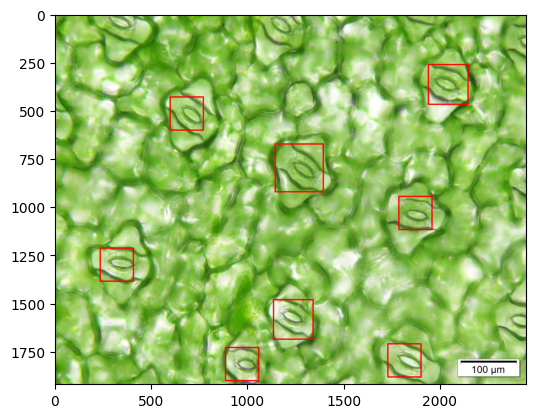

In [101]:
# 画像を１枚読み込む
image_file = image_files[0]
path = os.path.join(image_dir, image_file)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 推論
dets = detect(detector, image, det_width=512)
print(dets)  # xmin, ymin, xmax, ymaxのnested list

# 結果を描画する。元の画像を編集しないように新たな画像を用意する。
image2 = image.copy()
for det in dets:
    cv2.rectangle(image2, (det[0],det[1]), (det[2],det[3]), (255,0,0), 5)

plt.imshow(image2)

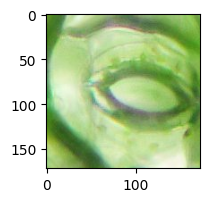

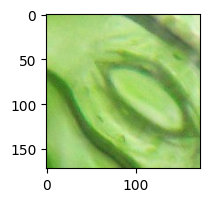

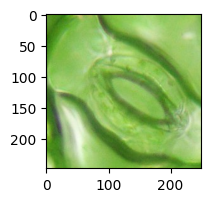

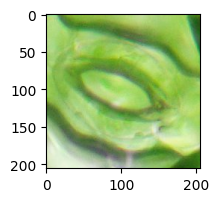

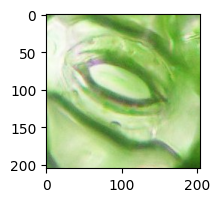

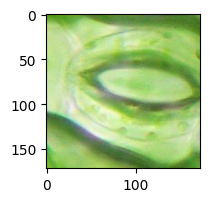

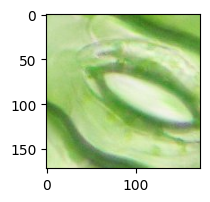

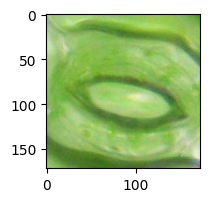

In [38]:
# 検出した座標をもとに気孔を切り抜くことができます。
for det in dets:
    stomata = image[det[1]:det[3], det[0]:det[2],:]
    plt.figure(figsize=(2,2))
    plt.imshow(stomata)
    plt.show()

このような訓練済み検出器を用いて画像から気孔を切り出すことができます。

HOGの解説を下に書く(todo)

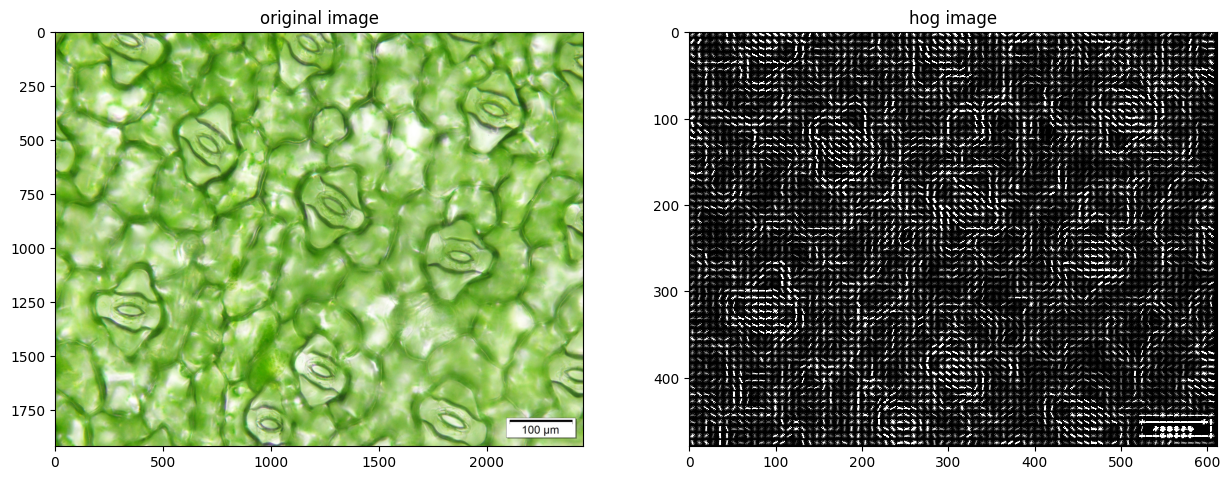

In [39]:
hog_template = cv2.resize(image, dsize=None, fx=0.25, fy=0.25)
hog_template = cv2.cvtColor(hog_template, cv2.COLOR_RGB2GRAY)
_, hog_image = feature.hog(hog_template, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),  block_norm='L2-Hys', visualize=True, transform_sqrt=True)
hog_image *= 255

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(image)
plt.subplot(1,2,2)
plt.title("hog image")
plt.imshow(hog_image, vmax=100, cmap="gray")

<img width=15% src="https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/imgs/hogimage.jpg?raw=true">

気孔検出モデルが探すHOGの平均的イメージ

### Step2: CNNによる気孔開閉分類（偽陽性判別含む）

In [27]:
def image_whitening(img):
    img = img.astype(np.float32)
    d, w, h = img.shape
    num_pixels = d * w * h
    mean = img.mean()
    variance = np.mean(np.square(img)) - np.square(mean)
    stddev = np.sqrt(variance)
    min_stddev = 1.0 / np.sqrt(num_pixels)
    scale = stddev if stddev > min_stddev else min_stddev
    img -= mean
    img /= scale
    return img

In [29]:
# 気孔開閉判定モデルの読み込み
classifier_path = "/content/drive/MyDrive/phenotyping_temp_assets/dscnn.onnx"
providers = ['CUDAExecutionProvider','CPUExecutionProvider']
ort_session = ort.InferenceSession(classifier_path, providers=providers)

# inputとoutputの名前を把握します。
input_names = [input.name for input in ort_session.get_inputs()]
output_names = [output.name for output in ort_session.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Input names: ['input_image:0']
Output names: ['softmax_output:0']


raw output: [1.00000000e+00 1.28064684e-20 7.02352012e-15 1.57169792e-14]
stat probability: [100.0, 0.0, 0.0, 0.0]
index with most highest value: 0
stomata state: open


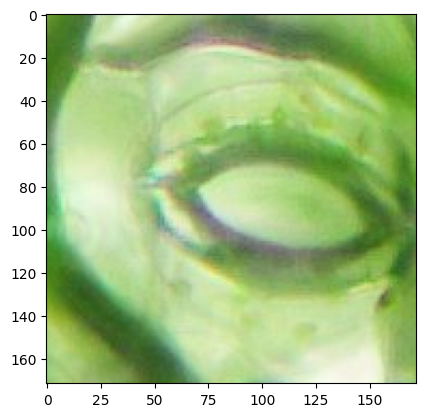

In [102]:
state_string = ["open", "closed", "partially open", "False Positive"]

# 前の検出器の推論で得られた気孔の座標detsを再利用します。
# １つ目の検出座標だけ使います。
d = dets[0]
# 気孔の切り出し
stomata = image[d[1]:d[3], d[0]:d[2], :]

# CNNのための画像の前処理
_stomata = stomata.copy()
_stomata = cv2.resize(_stomata, dsize=(56,56))
_stomata = image_whitening(_stomata)
_stomata = np.expand_dims(_stomata, axis=0)
# CNNによる推論
prediction = ort_session.run(["softmax_output:0"], {"input_image:0": _stomata})[0][0]

# 結果の表示
plt.imshow(stomata)
print("raw output:", prediction)
print("stat probability:", [np.round(x*100,3) for x in prediction])
idx = np.argmax(prediction)
print("index with most highest value:", idx)
print("stomata state:", state_string[idx])

この訓練済みCNNで得られる出力は、入力画像（気孔）に対する

**[開口状態スコア, 閉鎖状態スコア, 部分開口状態スコア,　気孔ではない状態スコア]**です。

CNN内部のsoftmax関数によって４つの状態の累計が１となるように調整されているので、値に100をかけることで、◯◯という状態である確率と解釈することができます。

上記の結果の場合、開口気孔である確率が100%との結果を得ることができました。

## Step3: regionpropsモジュールを利用した気孔開口領域の計算

In [107]:
cv2.imwrite("stomata.jpg",stomata)

True

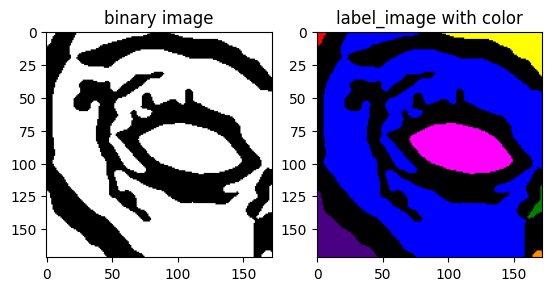

In [110]:
from skimage.filters import gaussian, threshold_local
from skimage.measure import label, regionprops
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_local
from skimage.morphology import binary_opening, binary_closing
from skimage.morphology import remove_small_holes
# from scipy.ndimage import gaussian_filter

_stomata = stomata.copy()
_stomata = rgb2gray(_stomata)
_stomata = gaussian(_stomata, sigma=3)
# _stomata = gaussian_filter(_stomata, sigma=3)
local_thresh = threshold_local(_stomata, 31, method="gaussian")
_stomata = _stomata > local_thresh
_stomata = binary_opening(_stomata)
_stomata = binary_closing(_stomata)

_stomata = remove_small_holes(_stomata, area_threshold=500)


lbl_image = label(_stomata)
_lbl = label2rgb(lbl_image)

plt.subplot(1,2,1)
plt.title("binary image")
plt.imshow(_stomata, cmap="gray")

plt.subplot(1,2,2)
plt.title("label_image with color")
plt.imshow(_lbl)

異なる色が異なるラベル領域を表しています。前項の種子解析と同様に、regionpropsで形状をとれば面積や開度（短軸長）が求まるでしょう。ただし、気孔開口領域ではない領域のフィルタリングをしなければなりません。ここで、

1. 一般に気孔開口領域は楕円であること、
2. 検出器をつかっていることから、画面中央寄りに気孔開口領域があること
3. 面積の下限、上限もある程度きまっていそうなこと。

このような条件をもとにregionpropsで得られる値をフィルタリングします。

initial prop no.: 7
filtered_props: 1


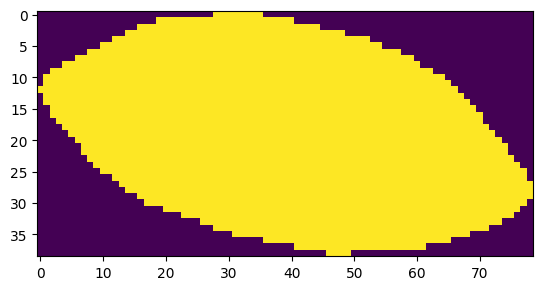

In [111]:
props = regionprops(lbl_image)
# フィルタ前領域数
print("initial prop no.:", len(props))

# ラムダ式を用いて条件に合致するかの式を完結に書くことができます。

criteria = [
    lambda r: r.area > 100,
    lambda r: r.area < 6000,
    lambda r: r.solidity > 0.8,
    lambda r: r.axis_major_length > 40,
    lambda r: r.extent > 0.5,
]

# 全部がtrueのものののみ残す
filtered_props = [r for r in props if all(criterion(r) for criterion in criteria)]
print("filtered_props:", len(filtered_props))

# 残った領域を描画する。regionpropsのimage attributeは単一ラベル領域のみの画像を保持する。
plt.imshow(filtered_props[0].image)

開口領域のみ抽出できました。
ここで、気孔開口領域と気孔開度は、それぞれラベル領域の面積と短軸長と等しいため、
下に示すコードで求めることができます。


In [68]:
print("stomatal pore area:", filtered_props[0].area)
print("stomatal aperture:", filtered_props[0].axis_minor_length)

stomatal pore area: 1861
stomatal aperture: 32.585371708668106


### DeepStomata（簡易実装版）全体コード

In [74]:
import dlib
import onnxruntime
import cv2
import os
import numpy as np
import pandas as pd
from skimage import feature
from skimage.filters import gaussian, threshold_local
from skimage.measure import label, regionprops
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_local
from skimage.morphology import binary_opening, binary_closing

import matplotlib.pyplot as plt
import onnxruntime as ort

In [114]:
image_dir = "/content/drive/MyDrive/phenotyping_temp_assets/examples"
image_files = sorted(os.listdir(image_dir))

classifier_path = "/content/drive/MyDrive/phenotyping_temp_assets/dscnn.onnx"
detector_path = "/content/drive/MyDrive/phenotyping_temp_assets/leafdisk161002_c_7.0.svm"

state_string = ["open", "closed", "partially open", "False Positive"]

criteria = [
    lambda r: r.area > 100,
    lambda r: r.area < 6000,
    lambda r: r.solidity > 0.8,
    lambda r: r.axis_major_length > 40,
    lambda r: r.extent > 0.5,
]

In [72]:
# 気孔検出器の読み込み
detector = dlib.simple_object_detector(detector_path)
# 気孔開閉判定モデルの読み込み
providers = ['CUDAExecutionProvider','CPUExecutionProvider']
ort_session = ort.InferenceSession(classifier_path, providers=providers)

In [112]:
def image_whitening(img):
    img = img.astype(np.float32)
    d, w, h = img.shape
    num_pixels = d * w * h
    mean = img.mean()
    variance = np.mean(np.square(img)) - np.square(mean)
    stddev = np.sqrt(variance)
    min_stddev = 1.0 / np.sqrt(num_pixels)
    scale = stddev if stddev > min_stddev else min_stddev
    img -= mean
    img /= scale
    return img

def detect(model, image, det_width):
    # 入力画像を縦横比を保ったまま、横幅512pxにリサイズして検出し、
    # 検出された気孔の画像を元のサイズの座標に変換して結果を返しています。
    height, width, _ = image.shape
    ratio = width / det_width
    height_det = int(round(height / ratio))
    width_det = int(round(width / ratio))
    scaled_image = cv2.resize(image, dsize=(width_det, height_det))
    _dets = detector(scaled_image)
    dets = []
    # scale back
    for _d in _dets:
        # xmin, ymin, xmax, ymax
        r = [_d.left(), _d.top(), _d.right(), _d.bottom()]
        r = [int(x * ratio) for x in r]
        dets.append(r)
    return dets

def filter_pore(stomata, criteria):
    stomata = rgb2gray(stomata)
    stomata = gaussian(stomata, sigma=7)
    local_thresh = threshold_local(stomata, 31, method="gaussian")
    stomata = stomata > local_thresh
    stomata = binary_opening(stomata)
    stomata = binary_closing(stomata)
    stomata = remove_small_holes(stomata, area_threshold=500)
    lbl_image = label(stomata)

    props = regionprops(lbl_image)
    filtered_props = [r for r in props if all(criterion(r) for criterion in criteria)]
    return filtered_props


In [118]:
result = []

for image_file in image_files:
    path = os.path.join(image_dir, image_file)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 気孔検出推論
    dets = detect(detector, image, det_width=512)
    # 結果描画。
    annotated = image.copy()
    for det in dets:
        cv2.rectangle(annotated, (det[0],det[1]), (det[2],det[3]), (255,0,0), 5)

    # 気孔開閉判定
    for det in dets:
        #結果を格納する際の初期値
        area = None
        aperture =None

        stomata = image[det[1]:det[3], det[0]:det[2], :]
        stomata = cv2.resize(stomata, dsize=(56,56))
        stomata = image_whitening(stomata)
        stomata = np.expand_dims(stomata, axis=0)
        prediction = ort_session.run(["softmax_output:0"], {"input_image:0": stomata})[0][0]

        idx = np.argmax(prediction)
        # 閉鎖気孔の場合、開度も面積も0
        if idx ==1:
            area = 0
            aperture = 0

        # 開口もしくは部分的に開口気孔と判定された場合、regionpropsによる解析を試みる。
        elif idx == 0 or idx == 2:
            props = filter_pore(stomata, criteria)
            # 候補領域が１つのみの場合、開口領域と仮定して面積と開度を結果に加える。
            if len(props) == 1:
                try:
                    area = props[0].area
                    aperture = props[0].axis_minor_length
                except:
                    area = None
                    aperture = None
            #　複数もしくは０の場合、解析できなかったとしてNoneにする
            else:
                area = None
                aperture = None
        #　それ以外の場合は偽陽性のみ結果はNone
        else:
            area = None
            aperture = None

        #結果をresultに追加
        r = [image_file, idx, area, aperture]
        result.append(r)

/usr/local/lib/python3.10/dist-packages/skimage/measure/_regionprops.py:395: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 160834053  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 55  Error-roundoff 7.6e-14  _one-merge 5.3e-13
  _near-inside 2.7e-12  Visible-distance 1.5e-13  U-max-coplanar 1.5e-13
  Width-outside 3.1e-13  _wide-facet 9.2e-13  _maxoutside 6.1e-13

  return convex_hull_image(self.image)
/usr/local/lib/python3.10/dist-packages/skimage/measure/_regionprops.py:395: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for

error: ignored

In [125]:
df = pd.DataFrame(result, columns=["file","stat", "area","aperture"])
df2 = df.dropna()
df2

,file,stat,area,aperture
0,1.jpg,0,2177.0,7.539457e-07
1,1.jpg,0,2328.0,0.000000e+00
9,10.jpg,1,0.0,0.000000e+00
10,10.jpg,2,1919.0,5.331201e-07
11,10.jpg,1,0.0,0.000000e+00
12,10.jpg,1,0.0,0.000000e+00
13,10.jpg,1,0.0,0.000000e+00
14,10.jpg,1,0.0,0.000000e+00
15,10.jpg,1,0.0,0.000000e+00
17,11.jpg,2,1783.0,0.000000e+00


<Axes: xlabel='file', ylabel='area'>

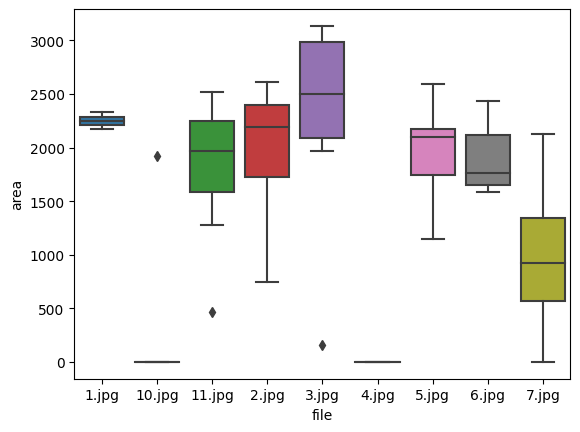

In [127]:
import seaborn as sns

sns.boxplot(df2, x="file", y="area")